# IMPRS NeuroCom Summer School
## Deep Learning and Vision hands-on session
### Martin Hebart, Katja Seeliger

We would like to know how well representations from early and higher visual cortex match representations from different DNN layers. 

For this we will compare **brain RDMs** from activations in early and higher visual cortex with **RDMs made from deep neural network features**. 

All activations correspond to the response to the same set of stimulus images.

*Credits: 92 stimulus images from Kriegeskorte lab. Brain activity for them acquired by Radoslaw Cichy.*

In [ ]:
!pip install --upgrade thingsvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 776 kB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 


In [ ]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from skimage import io
from google.colab.patches import cv2_imshow
from scipy.stats import spearmanr, pearsonr
from scipy.io import loadmat
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import rankdata

import thingsvision.vision as vision
from thingsvision.model_class import Model

In [ ]:
# data and images
if not os.path.exists('IMPRS_DNN_RDMs'): 
    !git clone https://github.com/kateiyas/IMPRS_DNN_RDMs

im_n = 92

Cloning into 'IMPRS_DNN_RDMs'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 109 (delta 3), reused 41 (delta 0), pack-reused 59
Receiving objects: 100% (109/109), 1.82 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
# load brain RDMs
brain_rdms = {}

brain_rdms['early'] =  loadmat('IMPRS_DNN_RDMs/RDM92_EVC.mat')['RDM92_EVC']
brain_rdms['higher'] = loadmat('IMPRS_DNN_RDMs/RDM92_HVC.mat')['RDM92_HVC']

for k in brain_rdms.keys():
    np.fill_diagonal( brain_rdms[k], 0.0 )

In [ ]:
# set up thingsvision (for simplified DNN activation extraction)
backend = 'pt'    # 'pt': pytorch | 'tf': tensorflow
batch_size = 4

# DNN layer activation tensors have spatial and channel dimensions, 
# e.g. [55 x 55 x 96] == [spatial x spatial x channel].
# For RDMs these DNN tensors are conventionally just flattened and regarded 
# as one long feature vector. 
flatten_activations = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# feature extraction helper for thingsvision
def extract_features( model, module_name, image_path, out_path, batch_size, flatten_activations, apply_center_crop, clip ):
    dl = vision.load_dl( root=image_path,
                         out_path=out_path,
                         batch_size=batch_size,
                         transforms=model.get_transformations(apply_center_crop=apply_center_crop),
                         backend=backend )

    features, _ = model.extract_features( data_loader=dl, 
                                          module_name=module_name, 
                                          flatten_acts=flatten_activations,
                                          clip=clip,
                                          return_probabilities=False )
    return features

In [ ]:
# load (and download) pretrained DNN model: VGG-16
vgg16 = Model( 'vgg16',
                pretrained=True,   # trained for binary classification on the 2012 ImageNet competition dataset (1000 classes)
                device=device,
                backend=backend  )

# some other models available in thingsvision: 
# alexnet, resnet18, resnet50, resnet101, vit_b_16, vit_b_32, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19, vgg19_bn, cornet-s, clip-ViT

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# check out VGG-16 layers (to take note of the layer indices)
vgg16.show()
# (Be aware that this will create an input prompt at the end of the output of the cell.)

# After convolutions, non-linearities (ReLU) and operations like pooling are usually applied, 
# so for each given 'DNN layer activation' there are multiple variants. Conventionally (in current
# literature) the activation is taken after dimensionalities change, e.g. after max pooling or
# channel number changes, otherwise after non-linerarities. 

# Let's take these 8 layers (feature: convolutional layers (more spatial information), 
# classifier: linear layers closer to the classification)
layer_selection = [ 'features.4', 'features.9', 'features.16', 'features.23', 'features.30', 
                    'classifier.1', 'classifier.4', 'classifier.6']

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Extract DNN features with `thingsvision`

In [ ]:
# To begin, we will create RDMs from a convolutional (early, more image-grounded) 
# and a fully-connected (higher, more semantically grounded) feature layer. 

extr_layers = { 'early':layer_selection[0], 
                'higher':layer_selection[6] }

extr_features = {}

for ft_type in extr_layers.keys(): 
    
    extr_features[ft_type] = extract_features( model = vgg16,
                                               module_name = extr_layers[ft_type],    # the layer we want to extract
                                               image_path = 'IMPRS_DNN_RDMs/rdm_ims/',
                                               out_path = 'features',
                                               batch_size = batch_size,
                                               flatten_activations = flatten_activations,
                                               apply_center_crop = False, 
                                               clip = False )

# Obviously, the stimulus images need to be arranged in the same 
# order across brain and feature RDMs (thingsvision implicitly sorts them). 


...Loading dataset into memory.
...Transforming dataset into pt DataLoader.

...Features successfully extracted for all 92 images in the database.
...Features shape: (92, 1048576)

...Loading dataset into memory.
...Transforming dataset into pt DataLoader.

...Features successfully extracted for all 92 images in the database.
...Features shape: (92, 4096)


### Compute representational distances for DNN features

In [ ]:
# RDM
def get_corr_rdm(features):
    # Usually features are not centered before creating the RDM. 

    n_ims = len(features)

    rdm = np.zeros( [n_ims, n_ims] )

    for i in range(n_ims): 
        for j in range(n_ims):

            if i==j:   # skip diagonal
                continue

            corr, _ = pearsonr( features[i], features[j] )
            rdm[i,j] = 1.0 - corr   # representational dis-similarity

    return rdm

In [ ]:
feat_rdms = {}
for ft_type in extr_layers.keys(): 
    feat_rdms[ft_type] = get_corr_rdm( extr_features[ft_type] )

### Visualize Representational Distance Matrices

**Feature RDMs**

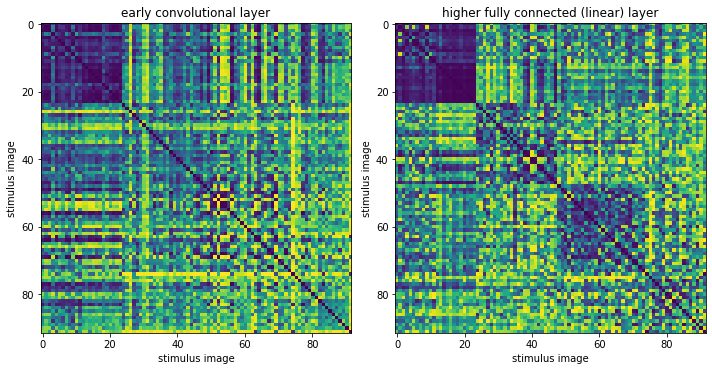

In [ ]:
# we will rank the RDM values for visualization (rankdata)
# for their comparison we are also using rank-order correlation metrics.

plt.figure( figsize=[10,7] )

plt.subplot(121)

plt.imshow( rankdata(feat_rdms['early']).reshape([im_n, im_n]), vmin=0. )
plt.title( "early convolutional layer" )
plt.xlabel( "stimulus image" )
plt.ylabel( "stimulus image" )

plt.subplot(122)

plt.imshow( rankdata(feat_rdms['higher']).reshape([im_n, im_n]), vmin=0. )
plt.title( "higher fully connected (linear) layer" )
plt.xlabel( "stimulus image" )
plt.ylabel( "stimulus image" )

plt.tight_layout()

**Brain RDMs**

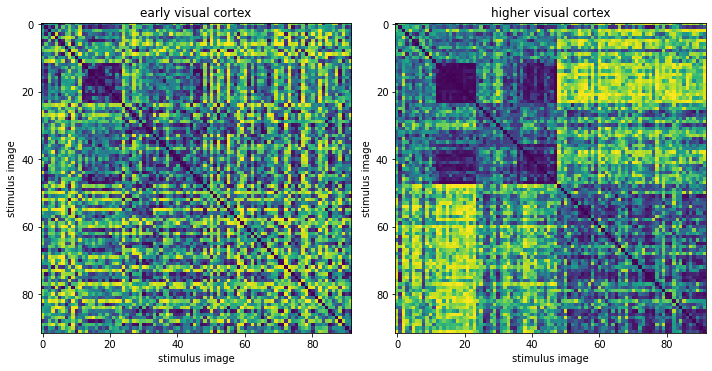

In [ ]:
# visualize brain RDMs
plt.figure( figsize=[10,7] )

plt.subplot(121)

plt.imshow( rankdata(brain_rdms['early']).reshape([im_n, im_n]), vmin=0. )
plt.title( "early visual cortex" )
plt.xlabel( "stimulus image" )
plt.ylabel( "stimulus image" )

plt.subplot(122)

plt.imshow( rankdata(brain_rdms['higher']).reshape([im_n, im_n]), vmin=0. )
plt.title( "higher visual cortex" )
plt.xlabel( "stimulus image" )
plt.ylabel( "stimulus image" )

plt.tight_layout()

### Check for similarity between DNN RDMs and brain RDMs

In [ ]:
# The matrices are symmetric, so we only want to correlate lower or upper triangles. 
brain_rdms_tri = {} ; feat_rdms_tri = {}
for ft_type in brain_rdms.keys():
    brain_rdms_tri[ft_type] = brain_rdms[ft_type][ np.triu_indices(brain_rdms[ft_type].shape[0], k=1) ]
    feat_rdms_tri[ft_type] = feat_rdms[ft_type][ np.triu_indices(feat_rdms[ft_type].shape[0], k=1) ]

In [ ]:
# Our criterion will be spearman's rho, a rank-order correlation. Some examples: 

rho, p = spearmanr(brain_rdms_tri['higher'], feat_rdms_tri['higher'])
print( "Spearman's rho RDM correlation between higher visual system and higher DNN features:\n rho: %.2f | p: %.2f \n" % (rho, p) )

rho, p = spearmanr(brain_rdms_tri['early'], feat_rdms_tri['early'])
print( "Spearman's rho RDM correlation between early visual system and early DNN features:\n rho: %.2f | p: %.2f \n" % (rho, p) )

rho, p = spearmanr(brain_rdms_tri['early'], feat_rdms_tri['higher'])
print( "Spearman's rho RDM correlation between early visual system and higher DNN features:\n rho: %.2f | p: %.2f \n" % (rho, p) )

rho, p = spearmanr(brain_rdms_tri['higher'], feat_rdms_tri['early'])
print( "Spearman's rho RDM correlation between higher visual system and early DNN features:\n rho: %.2f | p: %.2f \n" % (rho, p) )

# For these examples, the correlations differ in the way we would expect. 

Spearman's rho RDM correlation between higher visual system and higher DNN features:
 rho: 0.23 | p: 0.00 

Spearman's rho RDM correlation between early visual system and early DNN features:
 rho: 0.15 | p: 0.00 

Spearman's rho RDM correlation between early visual system and higher DNN features:
 rho: 0.09 | p: 0.00 

Spearman's rho RDM correlation between higher visual system and early DNN features:
 rho: 0.08 | p: 0.00 



In [ ]:
# Let's do this comparison for all the layers we have picked before. 
# This will take a few minutes to run.

HVC_corrs = np.zeros(len(layer_selection))
EVC_corrs = np.zeros(len(layer_selection))

rdms = {}

for i, layer in enumerate( layer_selection ):
    print(f"Processing layer {i+1}/{len(layer_selection)} ({layer})...")

    features =  extract_features( model = vgg16,
                                  module_name = layer, 
                                  image_path = 'IMPRS_DNN_RDMs/rdm_ims/',
                                  out_path = 'features',
                                  batch_size = batch_size,
                                  flatten_activations = flatten_activations,
                                  apply_center_crop = False, 
                                  clip = False )


    rdm = get_corr_rdm( features )
    rdm = rdm[ np.triu_indices(rdm.shape[0], k=1) ]
    rdms[layer] = rdm

    EVC_corrs[i],_ = spearmanr(brain_rdms_tri['early'], rdm)
    HVC_corrs[i],_ = spearmanr(brain_rdms_tri['higher'], rdm)

Processing layer 1/8 (features.4)...

...Loading dataset into memory.
...Transforming dataset into pt DataLoader.

...Features successfully extracted for all 92 images in the database.
...Features shape: (92, 1048576)
Processing layer 2/8 (features.9)...

...Loading dataset into memory.
...Transforming dataset into pt DataLoader.

...Features successfully extracted for all 92 images in the database.
...Features shape: (92, 524288)
Processing layer 3/8 (features.16)...

...Loading dataset into memory.
...Transforming dataset into pt DataLoader.

...Features successfully extracted for all 92 images in the database.
...Features shape: (92, 262144)
Processing layer 4/8 (features.23)...

...Loading dataset into memory.
...Transforming dataset into pt DataLoader.

...Features successfully extracted for all 92 images in the database.
...Features shape: (92, 131072)
Processing layer 5/8 (features.30)...

...Loading dataset into memory.
...Transforming dataset into pt DataLoader.

...Features s

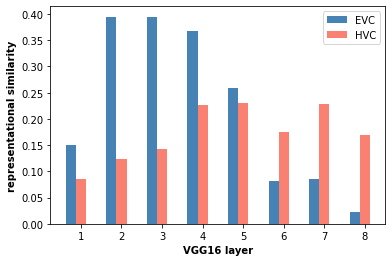

In [ ]:
# plot RDM correlations across layers
wbar = 0.25
 
r1 = np.arange(len(layer_selection))
r2 = [x + wbar for x in r1]
 
plt.bar(r1, EVC_corrs, color='steelblue', width=wbar, label='EVC')
plt.bar(r2, HVC_corrs, color='salmon', width=wbar, label='HVC')
 
plt.xlabel('VGG16 layer', fontweight='bold')
plt.xticks([r + wbar for r in range(len(layer_selection))], [str(i+1) for i in range(len(layer_selection))])

plt.ylabel('representational similarity', fontweight='bold')
plt.legend()

### Task for you

1. Replace the model with another DNN model (e.g. `alexnet`, `cornet-s` or `clip-vit` (option `clip` must be `True`). You need to choose a different set of layers for your network and put them into `layer_selection`.

2. Recreate the bar plots with RDM comparisons between DNN features and higher and lower visual system. How does your chosen network do? 